<a href="https://colab.research.google.com/github/karandomguy/NST-Neural-Style-Transfer-/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

# Get the VGG19 Model

In [2]:
from torchvision import models
vgg = models.vgg19(pretrained=True).features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 95.2MB/s]


## Moving model to GPU

In [89]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Freeze the Parameters in VGG, as we dont need backprob
#### We are going to change only the target image

In [4]:
for param in vgg.parameters():
    param.requires_grad_(False)

# Get the Content and Style image

In [93]:
from PIL import Image
content_img = Image.open('sunsetudupi.jpeg')
style_img = Image.open('styleimg2.jpeg')

## Content Image

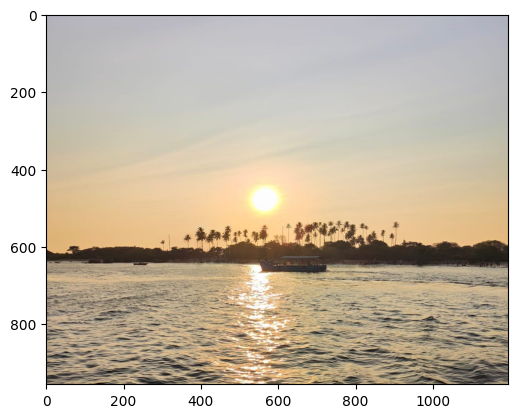

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(content_img)
plt.grid(False)
plt.show()

## Style Image

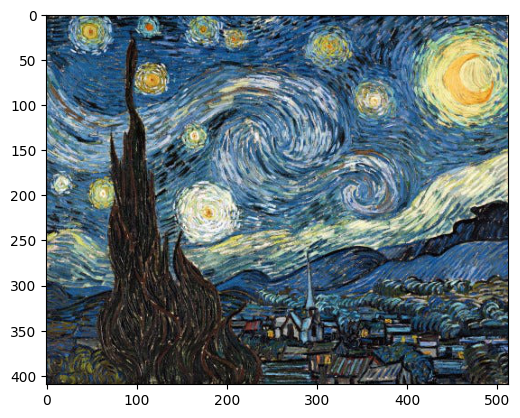

In [95]:
plt.imshow(style_img)
plt.grid(False)
plt.show()

# Image transform

In [96]:
from torchvision import transforms
img_transform = transforms.Compose([transforms.Resize((400, 400)),
                transforms.ToTensor(),
                transforms.Normalize((0.485,0.456, 0.406),(0.229,0.224, 0.225))])

content = img_transform(content_img)[:3,:,:].unsqueeze(0).to(device)
style = img_transform(style_img)[:3,:,:].unsqueeze(0).to(device)

# Get the feature layers

In [97]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [98]:
feature_layers = {'0': 'conv1_1',
          '5': 'conv2_1',
          '10': 'conv3_1',
          '19': 'conv4_1',
          '21': 'conv4_2',
          '28': 'conv5_1'}

### Content features

In [99]:
content_features = {}
img = content # copy of content image
for name, layer in vgg._modules.items():
 img = layer(img)
 if name in feature_layers:
    content_features[feature_layers[name]] = img

### Style features

In [100]:
style_features = {}
img = style # copy of content image
for name, layer in vgg._modules.items():
 img = layer(img)
 if name in feature_layers:
    style_features[feature_layers[name]] = img

In [101]:
# a general function to exrtract the features
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

# Style Matrix

In [102]:
def grammatrix(tensor):
    n, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    grammat = torch.mm(tensor, tensor.t())
    return grammat

In [103]:
style_gram_matrix = {layer: grammatrix(style_features[layer]) for layer in style_features}

# Target Image

In [104]:
target = content.clone().requires_grad_(True).to(device)

# Weights initialization

In [105]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # this is alpha in the final loss
style_weight = 1e6  # this is beta in the final loss

# Training loop

In [106]:
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

Total loss:  29257028.0


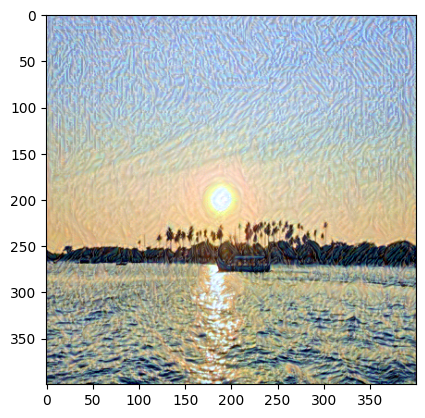

Total loss:  11919065.0


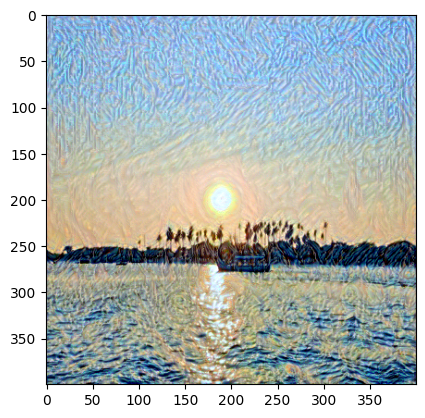

Total loss:  7340060.0


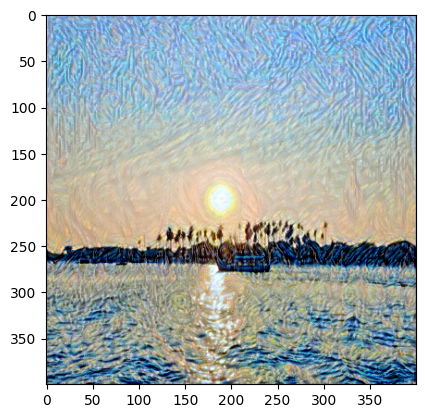

Total loss:  4849629.0


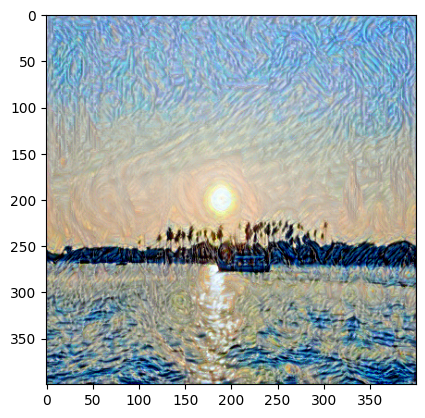

Total loss:  3436720.25


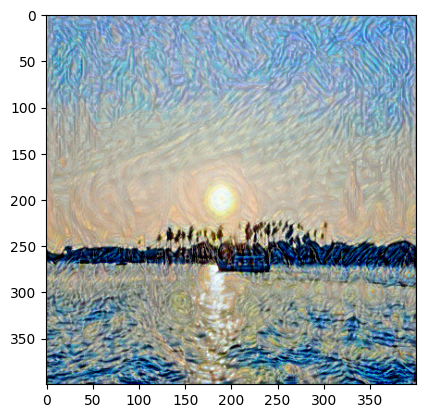

In [107]:
from torch import optim
import numpy as np

show_img = 400

optimizer = optim.Adam([target], lr=0.003)
steps = 2000

for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = grammatrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_gram_matrix[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()


    if  ii % show_img == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

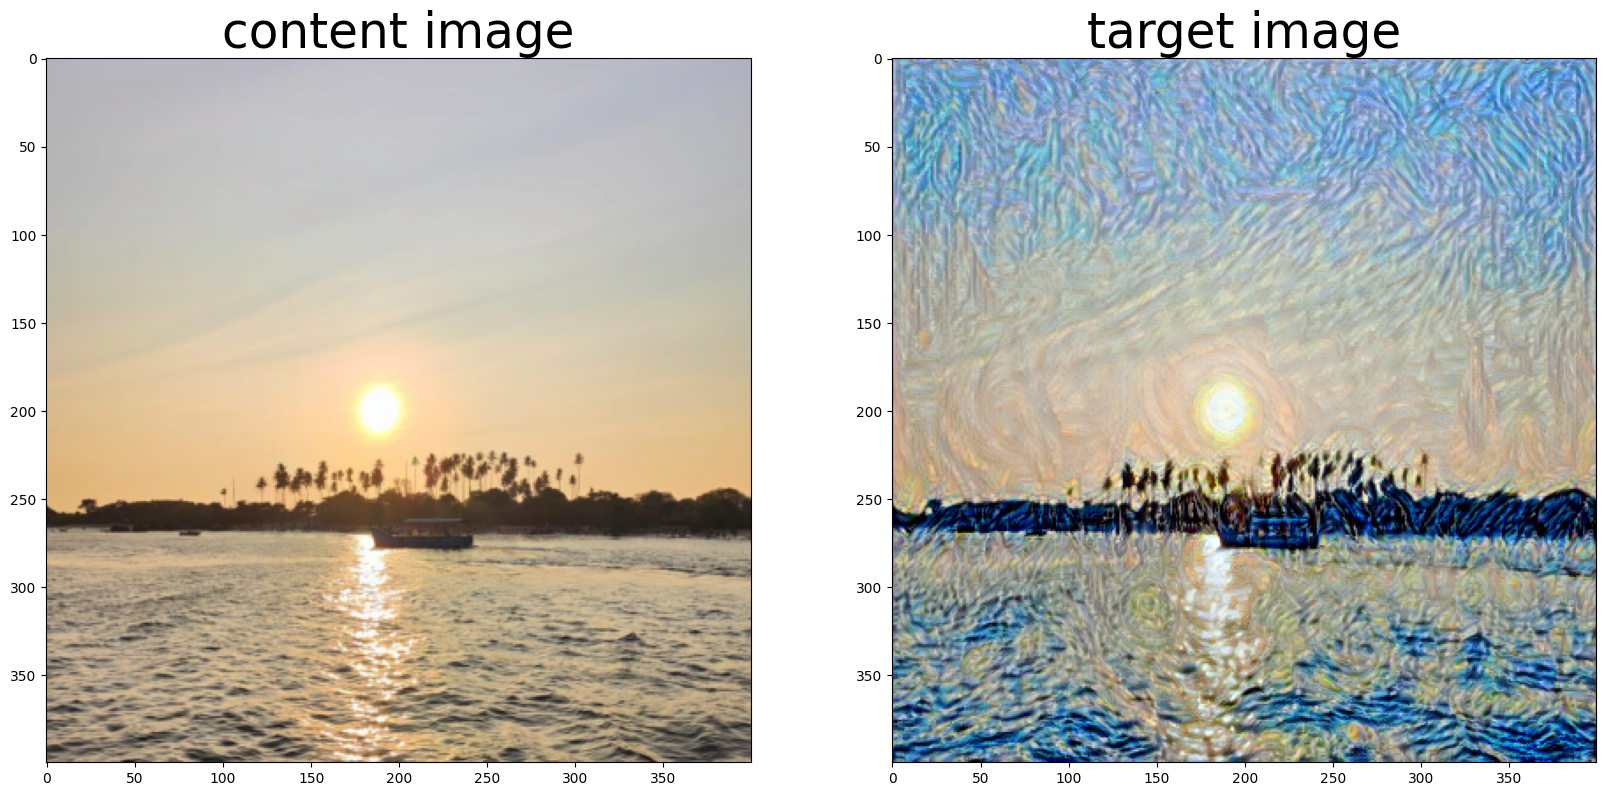

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.grid(False)
ax2.grid(False)
ax1.set_title('content image', fontsize="35", color="black")
ax2.set_title('target image', fontsize="35", color="black")
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
plt.show()